In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from keras.optimizers import Adam


# Load the GearBox data

In [2]:
import load_data

pth1 = 'data/BrokenTooth'
pth2 = 'data/Healthy'

window_len = 300  # How many window_len as 1 feature point 
inference_data_point = 5 # This value should be considered the MCU rom size. 5*300*10*2 = 30000 float points

broken_df_train, broken_df_test  = load_data.create_test_train_df_fromRaw(pth1 , 1, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))        
healthy_df_train, healthy_df_test = load_data.create_test_train_df_fromRaw(pth2 , 0, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))

#broken_df  = load_data.create_df_fromRaw(pth1 , 1, (load_data.addCol_load, load_data.addCol_fault))        
#healthy_df = load_data.create_df_fromRaw(pth2 , 0, (load_data.addCol_load, load_data.addCol_fault))

In [3]:
broken_df_test
#broken_df_train

,a1,a2,a3,a4,load,fault
0,2.350390,1.454870,-1.667080,-2.055610,0.0,1.0
1,2.452970,1.400100,-2.825100,0.984487,0.0,1.0
2,-0.241284,-0.267390,0.793540,0.605862,0.0,1.0
3,1.130270,-0.890918,0.696969,0.613068,0.0,1.0
4,-1.296140,0.980479,-1.130560,-0.346971,0.0,1.0
...,...,...,...,...,...,...
14995,-3.443520,-0.361539,-0.376093,-2.447550,90.0,1.0
14996,2.458310,-2.838840,0.191190,-0.201169,90.0,1.0
14997,-0.755909,3.982960,-2.321580,0.749357,90.0,1.0
14998,1.299520,4.402300,-2.232460,0.535038,90.0,1.0


# Feature Process

In [4]:
import feature_process

# Calculate the windows size features, combine 300 data as 1 points. 
Data_healthy, Lable_healthy = feature_process.window_feature_autoencoder(healthy_df_train, 0, window_len, 4, 16)#200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken, Lable_broken = feature_process.window_feature_autoencoder(broken_df_train, 1, window_len, 4, 16)
print(type(Data_healthy), type(Lable_healthy))
print("feature array shape of healthy point: {}, {}".format(Data_healthy.shape, Lable_healthy.shape))
print("feature array shape of broken point: {}, {}".format(Data_broken.shape, Lable_broken.shape))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
feature array shape of healthy point: (3336, 16), (3336,)
feature array shape of broken point: (3301, 16), (3301,)


In [5]:
# Create the random 80% train and 20% test
train_data, test_data, train_labels, test_labels = feature_process.concatenate_data(Data_healthy,Data_broken,Lable_healthy,Lable_broken, 0.1, 21)
print("train data shape: {}, {}".format(train_data.shape, train_labels.shape))
print("test data shape: {}, {}".format(test_data.shape, test_labels.shape))
# save the max&min val
max_val = tf.reduce_max(train_data)
min_val = tf.reduce_min(train_data)


train data shape: (5973, 16), (5973,)
test data shape: (664, 16), (664,)


# DNN

## DNN training

In [17]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

early_stop = EarlyStopping(monitor='loss', patience=2)
model = Sequential()

model.add(Dense(4, input_shape=(16,),kernel_initializer='random_uniform'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(8, kernel_initializer='random_uniform'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(16, kernel_initializer='random_uniform'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(8, kernel_initializer='random_uniform'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(2, activation='softmax',kernel_initializer='random_uniform'))
model_settings = {}

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
 activation_4 (Activation)   (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 8)                 40        
                                                                 
 activation_5 (Activation)   (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 16)                144       
                                                                 
 activation_6 (Activation)   (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                

In [18]:
hist = model.fit(train_data , train_labels , epochs=100, batch_size=32, validation_split=0.2)
#, batch_size=1024

Epoch 1/100
150/150 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5452 - val_loss: 0.6920 - val_accuracy: 0.8586
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.9232 - val_loss: 0.6752 - val_accuracy: 0.8753
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.8972 - val_loss: 0.5873 - val_accuracy: 0.8954
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 0.5025 - accuracy: 0.9242 - val_loss: 0.4107 - val_accuracy: 0.9456
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 0.9569 - val_loss: 0.2542 - val_accuracy: 0.9674
Epoch 6/100
150/150 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9644 - val_loss: 0.1654 - val_accuracy: 0.9766
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9663 - val_loss: 0.1247 - val_accuracy: 0.9774

## Test Result

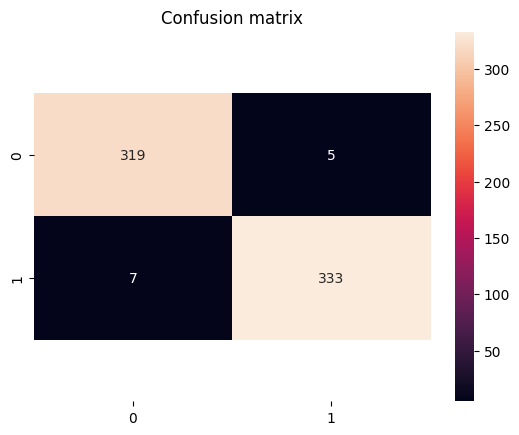

ROOT MEAN SQUARE ERROR = 0.13443321448446624
Accuracy = 0.9819277108433735
Precision = 0.985207100591716
Recall = 0.9794117647058823


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

Dnn_model = model  # pass the model in order to be used latter

def CF_Matrix_show(model, test_data, test_labels):
    prediction = model.predict(test_data,verbose = 0)
    #print(test_data[0:2])
    #print(prediction)
    y_pred = np.argmax(prediction,axis = -1)
    
    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(test_labels, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
    # The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion matrix")
    plt.show()
    pred = y_pred.astype(int)
    
    # Calculating root mean square error
    rmse = np.sqrt(np.mean(((pred - test_labels) ** 2)))
    print("ROOT MEAN SQUARE ERROR = {}".format(rmse))
    print("Accuracy = {}".format(accuracy_score(test_labels,pred)))
    print("Precision = {}".format(precision_score(test_labels,pred)))
    print("Recall = {}".format(recall_score(test_labels,pred)))


CF_Matrix_show(Dnn_model, test_data, test_labels)

# QAT for keeping accuracy

In [9]:
import tensorflow_model_optimization as tfmot

In [21]:
quant_aware_model = tfmot.quantization.keras.quantize_model(Dnn_model)
optimizer = Adam(learning_rate=0.0001)
quant_aware_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
quant_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_2 (QuantizeL  (None, 16)               3         
 ayer)                                                           
                                                                 
 quant_dense_5 (QuantizeWrap  (None, 4)                69        
 perV2)                                                          
                                                                 
 quant_activation_4 (Quantiz  (None, 4)                3         
 eWrapperV2)                                                     
                                                                 
 quant_dense_6 (QuantizeWrap  (None, 8)                41        
 perV2)                                                          
                                                                 
 quant_activation_5 (Quantiz  (None, 8)               

In [22]:
hist = quant_aware_model.fit(train_data , train_labels , epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
150/150 [==============================] - 1s 5ms/step - loss: 0.7813 - accuracy: 0.7114 - val_loss: 0.1930 - val_accuracy: 0.9741
Epoch 2/5
150/150 [==============================] - 1s 4ms/step - loss: 0.1797 - accuracy: 0.9694 - val_loss: 0.1460 - val_accuracy: 0.9724
Epoch 3/5
150/150 [==============================] - 1s 4ms/step - loss: 0.1371 - accuracy: 0.9648 - val_loss: 0.1060 - val_accuracy: 0.9715
Epoch 4/5
150/150 [==============================] - 1s 4ms/step - loss: 0.1089 - accuracy: 0.9661 - val_loss: 0.0879 - val_accuracy: 0.9707
Epoch 5/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0923 - accuracy: 0.9676 - val_loss: 0.0734 - val_accuracy: 0.9774


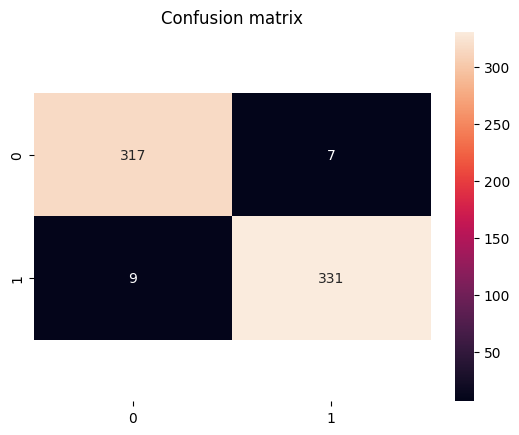

ROOT MEAN SQUARE ERROR = 0.1552301051412666
Accuracy = 0.9759036144578314
Precision = 0.9792899408284024
Recall = 0.9735294117647059


In [23]:
CF_Matrix_show(quant_aware_model, test_data, test_labels)

# TensorFlow Lite Conversion

In [1]:
# If we're happy with the performance, save the model
ori_model = quant_aware_model
keras_model_name = 'dnn'

tf.saved_model.save(ori_model, keras_model_name)

NameError: name 'quant_aware_model' is not defined

In [25]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
tflite_model = converter.convert()
open(os.path.join(keras_model_name,(keras_model_name + '.tflite')), 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpt6nc7lx1\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpt6nc7lx1\assets


11496

In [31]:
def tflite_to_tflu(models_path, c_model_name, keras_model_name, threshold, maxV, minV):
    
    tflite_name = os.path.join(keras_model_name,(keras_model_name + '.tflite'))
    my_f_name = (os.path.join(models_path, c_model_name) + '.cc')
    ! python tflite_to_tflu_para.py --tflite_path $tflite_name --output_path $my_f_name --window_size_sample $window_len --max_val_train $maxV --min_val_train $minV --threshold_val $threshold

models_path = 'model'
c_model_name = r'Gearbox_fault_' + keras_model_name    
tflite_to_tflu(models_path, c_model_name, keras_model_name, 0, max_val.numpy(), min_val.numpy())    

# Convert to int8 tflite and testing

In [32]:
# Convert the model to the TensorFlow Lite format with quantization
NUM_REP_DATA_SAMPLES = 300
def _rep_dataset():
    """Generator function to produce representative dataset."""
    for idx in range(len(train_data)):
        if idx >= NUM_REP_DATA_SAMPLES:
            break
        yield [tf.dtypes.cast(train_data[idx], tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
converter.representative_dataset = _rep_dataset
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()
open(os.path.join(keras_model_name,(keras_model_name + '_quantized.tflite')), 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpuhjgufxd\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpuhjgufxd\assets
C:\ProgramData\miniforge3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


4320

In [33]:
def tflite_inference(input_data, tflite_path):
    """Call forwards pass of TFLite file and returns the result.

    Args:
        input_data: Input data to use on forward pass.
        tflite_path: Path to TFLite file to run.

    Returns:
        Output from inference.
    """
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_dtype = input_details[0]["dtype"]
    output_dtype = output_details[0]["dtype"]

    # Check if the input/output type is quantized,
    # set scale and zero-point accordingly
    if input_dtype == np.int8:
        input_scale, input_zero_point = input_details[0]["quantization"]
    else:
        input_scale, input_zero_point = 1, 0

    input_data = input_data / input_scale + input_zero_point
    input_data = np.round(input_data) if input_dtype == np.int8 else input_data

    if output_dtype == np.int8:
        output_scale, output_zero_point = output_details[0]["quantization"]
    else:
        output_scale, output_zero_point = 1, 0

    interpreter.set_tensor(input_details[0]['index'], tf.cast(input_data, input_dtype))
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)

    return output_data

def calculate_accuracy(predicted_indices, expected_indices):
    """Calculates and returns accuracy.

    Args:
        predicted_indices: List of predicted integer indices.
        expected_indices: List of expected integer indices.

    Returns:
        Accuracy value between 0 and 1.
    """
    correct_prediction = tf.equal(predicted_indices, expected_indices)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [34]:
tflite_path = os.path.join(keras_model_name,(keras_model_name + '_quantized.tflite'))

predicted_indices = []  

for data, label in zip(test_data, test_labels):  # pylint: disable=unused-variable
    prediction = tflite_inference(tf.expand_dims(data, axis=0), tflite_path)
    predicted_indices.append(np.squeeze(tf.argmax(prediction, axis=1)))

test_accuracy = calculate_accuracy(predicted_indices, test_labels)
confusion_matrix = tf.math.confusion_matrix(labels=tf.constant(test_labels), 
                                            predictions=predicted_indices,
                                            num_classes = 2)
print(confusion_matrix.numpy())
print(f'Test accuracy = {test_accuracy * 100:.2f}%')

[[312  12]
 [  5 335]]
Test accuracy = 97.44%
